Goal of this notebook is to get familiar with idea of using gaussian random fourier features to embed high-frequency features before feeding them into the NNs.   
This allows them to learn data better, as research shows that low-frequency features are easier to learn for a NN.   
Below there is an implementation of the experiments from the paper [Fourier Features Let Networks Learn
High Frequency Functions in Low Dimensional Domains](https://arxiv.org/pdf/2006.10739) on which this notebook is based.   
Original implementation of the experiments with image regression is done in JAX, but implementation below is done using PyTorch.

In [1]:
%pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
from torcheval.metrics.functional import peak_signal_noise_ratio
from PIL import Image 
from matplotlib import pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = "zurich.jpeg" # Image on which experiments will be concducted

In [3]:
def read_and_transform_image(image_path: str) -> torch.Tensor:
    img = Image.open(image_path)

    img = transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor()
    ])(img)

    # Change the original image shape from the C x H x W to H x W x C
    return img.permute(1, 2, 0)

def tensor_to_image(image_tensor: torch.Tensor) -> Image:
    # Reverse the shape change
    return F.to_pil_image(image_tensor.permute(2, 0, 1))

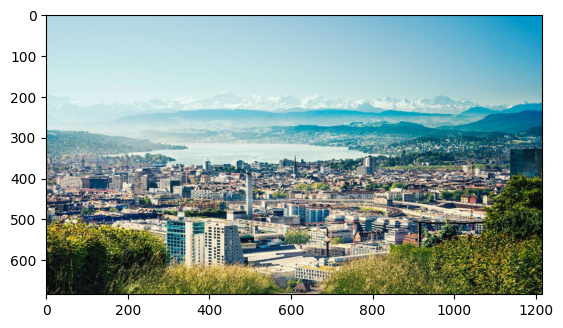

In [4]:
# Original image
plt.imshow(Image.open(image_path))


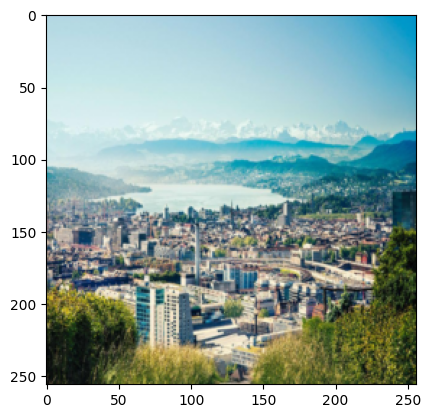

In [5]:
# After transforms
plt.imshow(tensor_to_image(read_and_transform_image(image_path)))


In [6]:
def make_model(num_layers: int, width: int, input_size: int):
    """Takes as an input x, y coordinates and tries to predict the r, g, b values for this pixel coord.
    It basically overfits to the given image.
    """
    if num_layers < 2:
        print(f"Minimum feasible number of layers is 2, adjusting...")
        num_layers = 2

    layers = [
        torch.nn.Linear(input_size, width),
        torch.nn.ReLU()
        ]

    for _ in range(num_layers-2):
        layers.append(torch.nn.Linear(width, width))
        layers.append(torch.nn.ReLU())

    layers.append(torch.nn.Linear(width, 3))
    layers.append(torch.nn.Sigmoid())
    
    return torch.nn.Sequential(*layers)
        

In [7]:
def make_embeddings(input_tensor: torch.Tensor, embedding_size: int, gaussian_scale: int=14) -> torch.Tensor:
    """Maps the input tensor from the H x W x C to fourier features of shape H x W x 2M where M is the embedding_size.
    """
    # C x M samples taken from the normal distribution scaled with gaussian_scale
    b_mat = torch.randn((input_tensor.shape[-1], embedding_size)).to(device) * gaussian_scale

    x = input_tensor @ b_mat
    x *= 2 * np.pi

    return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)


In [8]:
# Common parameters
epochs = 2000
depth = 4
width = 256
lr = 1e-4

sample_images_number = 5

image_tensor = read_and_transform_image(image_path).to(device)

coords = np.linspace(0, 1, image_tensor.shape[0], endpoint=False)

xy_grid = np.stack(np.meshgrid(coords, coords), -1)
xy_grid = torch.tensor(xy_grid).float().to(device)

In [9]:
input_size = 2

network_classic = make_model(depth, width, input_size).to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network_classic.parameters(), lr=lr)

loss_per_epoch_classic = []
psnr_per_epoch_classic = []
image_samples_classic = []


for epoch in range(epochs):
    optimizer.zero_grad()

    output = network_classic(xy_grid)

    l = loss(image_tensor, output)
    l.backward()

    optimizer.step()

    loss_per_epoch_classic.append(l.item())
    psnr_per_epoch_classic.append(peak_signal_noise_ratio(output, image_tensor).item())


    if epoch % 100 == 0:
        print(f'Epoch = {epoch}, loss = {l.item():4f}')
    
    if epoch % (epochs // sample_images_number) == 0:
        image_samples_classic.append(tensor_to_image(output.detach().cpu()))



Epoch = 0, loss = 0.075071
Epoch = 100, loss = 0.032536
Epoch = 200, loss = 0.026019
Epoch = 300, loss = 0.023501
Epoch = 400, loss = 0.021944
Epoch = 500, loss = 0.020650
Epoch = 600, loss = 0.019777
Epoch = 700, loss = 0.019246
Epoch = 800, loss = 0.018853
Epoch = 900, loss = 0.018521
Epoch = 1000, loss = 0.018211
Epoch = 1100, loss = 0.017917
Epoch = 1200, loss = 0.017644
Epoch = 1300, loss = 0.017392
Epoch = 1400, loss = 0.017160
Epoch = 1500, loss = 0.016955
Epoch = 1600, loss = 0.016772
Epoch = 1700, loss = 0.016604
Epoch = 1800, loss = 0.016454
Epoch = 1900, loss = 0.016320


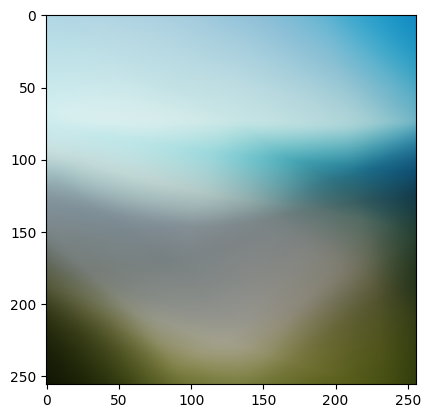

In [10]:
plt.imshow(image_samples_classic[-1])


In [11]:
input_size = 256
embedding_size = 128

network_fourier = make_model(depth, width, input_size).to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network_fourier.parameters(), lr=lr)

embedded_input = make_embeddings(xy_grid, embedding_size=embedding_size)

loss_per_epoch_fourier = []
psnr_per_epoch_fourier = []
image_samples_fourier = []

for epoch in range(epochs):
    optimizer.zero_grad()

    output = network_fourier(embedded_input)

    l = loss(image_tensor, output)
    l.backward()

    optimizer.step()

    loss_per_epoch_fourier.append(l.item())
    psnr_per_epoch_fourier.append(peak_signal_noise_ratio(output, image_tensor).item())

    if epoch % 100 == 0:
        print(f'Epoch = {epoch}, loss = {l.item():4f}')
        image_samples_fourier.append(tensor_to_image(output.detach().cpu()))


Epoch = 0, loss = 0.074810
Epoch = 100, loss = 0.040497
Epoch = 200, loss = 0.009487
Epoch = 300, loss = 0.004466
Epoch = 400, loss = 0.003148
Epoch = 500, loss = 0.002440
Epoch = 600, loss = 0.001972
Epoch = 700, loss = 0.001645
Epoch = 800, loss = 0.001407
Epoch = 900, loss = 0.001221
Epoch = 1000, loss = 0.001078
Epoch = 1100, loss = 0.000964
Epoch = 1200, loss = 0.000873
Epoch = 1300, loss = 0.000799
Epoch = 1400, loss = 0.000736
Epoch = 1500, loss = 0.000688
Epoch = 1600, loss = 0.000640
Epoch = 1700, loss = 0.000600
Epoch = 1800, loss = 0.000567
Epoch = 1900, loss = 0.000537


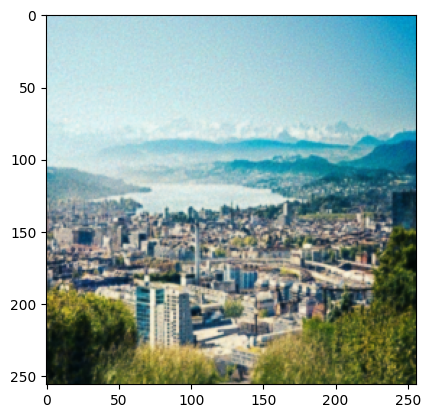

In [12]:
plt.imshow(image_samples_fourier[-1])


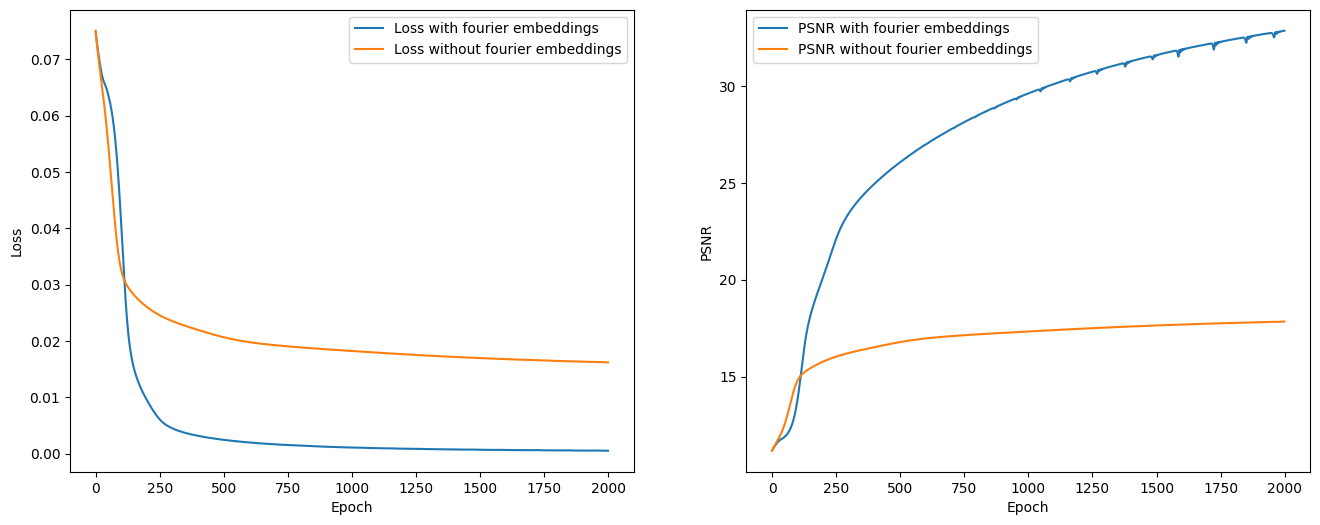

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), loss_per_epoch_fourier, label='Loss with fourier embeddings')
plt.plot(np.arange(epochs), loss_per_epoch_classic, label='Loss without fourier embeddings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), psnr_per_epoch_fourier, label='PSNR with fourier embeddings')
plt.plot(np.arange(epochs), psnr_per_epoch_classic, label='PSNR without fourier embeddings')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()

plt.show()

As we can see from the plots, random fourier feature mapping achieves much smaller loss in comparison to the data without any embeddings on the simple MLP. For the PSNR we can also see that the results are greatly in favor of the fourier mapping.

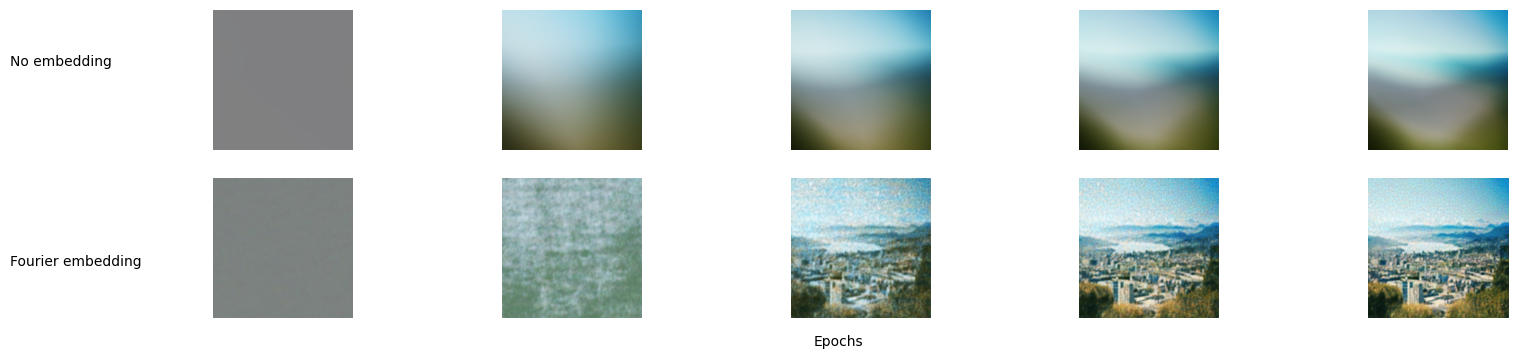

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=sample_images_number, figsize=(18, 4))

for i in range(sample_images_number):
    axes[0][i].imshow(image_samples_classic[i])
    axes[0][i].axis("off")
    axes[1][i].imshow(image_samples_fourier[i])
    axes[1][i].axis("off")

fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.04, 0.75, 'No embedding', va='center')
fig.text(0.04, 0.25, 'Fourier embedding', va='center')
plt.show()

Lastly, on the 5 images taken from the training of both MLPs we can see the visual difference between the image representation learned by both networks.   
Output from the MLP using fourier mapping is indistinguishable from the original one. In comparison, the other one clearly shows that low-frequency trends (colors over given area, shapes) were learned quite well, however high-frequency details are missing.